# Preprocess HINT PPI Network
This notebook prepares the [HINT](https://hint.yulab.org/download) PPI network for use with graph convolutional networks.
I use version `2024-6`, downloaded from [here](https://hint.yulab.org/download-raw/2024-06/HomoSapiens_cocomp_all.txt) and preprocessed in the following way:

* filter out duplicate and selfloop edges

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
hint_ppis = pd.read_csv('HomoSapiens_cocomp_all.txt',header=0,sep='\t')
hint_ppis

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,pmid:method:quality:type,taxid,high_quality,in_pdb_source
0,A0A024R0H7,Q8TB24,NaN,RIN3,32552912:0007:LC:co-complex,9606,True,False
1,A0A024R0L6,Q5S007,NaN,LRRK2,31046837:0007:LC:co-complex,9606,True,False
2,A0A024R1A3,Q5S007,NaN,LRRK2,31046837:0007:LC:co-complex,9606,True,False
3,A0A024R2I8,O15379,NR1A2,HDAC3,17242407:0004:LC:co-complex,9606,False,False
4,A0A024R2I8,O75376,NR1A2,NCOR1,17242407:0004:LC:co-complex,9606,False,False
...,...,...,...,...,...,...,...,...
606898,Q9Y6W8,Q9Y6W8,ICOS,ICOS,11169414:0004:LC:co-complex,9606,False,False
606899,Q9Y6X3,Q9Y6X3,MAU2,MAU2,31010829:0004:LC:co-complex,9606,False,False
606900,Q9Y6X9,Q9Y6X9,MORC2,MORC2,31796101:0004:LC:co-complex,9606,False,True
606901,Q9Y6Y0,Q9Y6Y0,IVNS1ABP,IVNS1ABP,23825951:0004:LC:co-complex,9606,False,True


In [13]:
edgelist = hint_ppis.loc[:,'Gene_A':'Gene_B']
edgelist.set_index([np.arange(edgelist.shape[0])], inplace=True)
edgelist['confidence'] = 1
edgelist.columns = ['partner1', 'partner2', 'confidence']
edgelist

,partner1,partner2,confidence
0,NaN,RIN3,1
1,NaN,LRRK2,1
2,NaN,LRRK2,1
3,NR1A2,HDAC3,1
4,NR1A2,NCOR1,1
...,...,...,...
606898,ICOS,ICOS,1
606899,MAU2,MAU2,1
606900,MORC2,MORC2,1
606901,IVNS1ABP,IVNS1ABP,1


In [14]:
hint_ppis_nona = edgelist.dropna()
hint_ppis_nona

,partner1,partner2,confidence
3,NR1A2,HDAC3,1
4,NR1A2,NCOR1,1
5,NR1A2,TP53,1
6,NR1A2,PARP1,1
7,NR1A2,NR2F6,1
...,...,...,...
606898,ICOS,ICOS,1
606899,MAU2,MAU2,1
606900,MORC2,MORC2,1
606901,IVNS1ABP,IVNS1ABP,1


## filter out duplicate and selfloop edges

In [15]:
num_duplicated_edges = hint_ppis_nona.duplicated(subset=['partner1', 'partner2']).sum()
edgelist.drop_duplicates(subset=['partner1', 'partner2'], inplace=True)
print ("Duplicated Edges: {} -> New #Edges: {}".format(num_duplicated_edges,
                                                       edgelist.shape[0]))

Duplicated Edges: 27938 -> New #Edges: 578279


In [16]:
G = nx.from_pandas_edgelist(hint_ppis_nona, source='partner1', target='partner2', edge_attr='confidence')
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))

Constructed Adjacency Matrix with average node degree of: 65.88442815417216
Adjacency matrix has 575204 edges and 17461 nodes in total


In [17]:
edgelist_no_repeat = nx.to_pandas_edgelist(G)
edgelist_no_repeat.columns=['partner1','partner2','confidence'] # rename columns names
edgelist_no_repeat.to_csv('HINT_symbols_no_repeat.tsv',sep='\t',index=False)
edgelist_no_repeat

,partner1,partner2,confidence
0,NR1A2,HDAC3,1
1,NR1A2,NCOR1,1
2,NR1A2,TP53,1
3,NR1A2,PARP1,1
4,NR1A2,NR2F6,1
...,...,...,...
575199,VMAC,SMR3A,1
575200,CYGB,GPR65,1
575201,GAGE2E,GMCL2,1
575202,TRIM61,VXN,1


D:\devtool\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

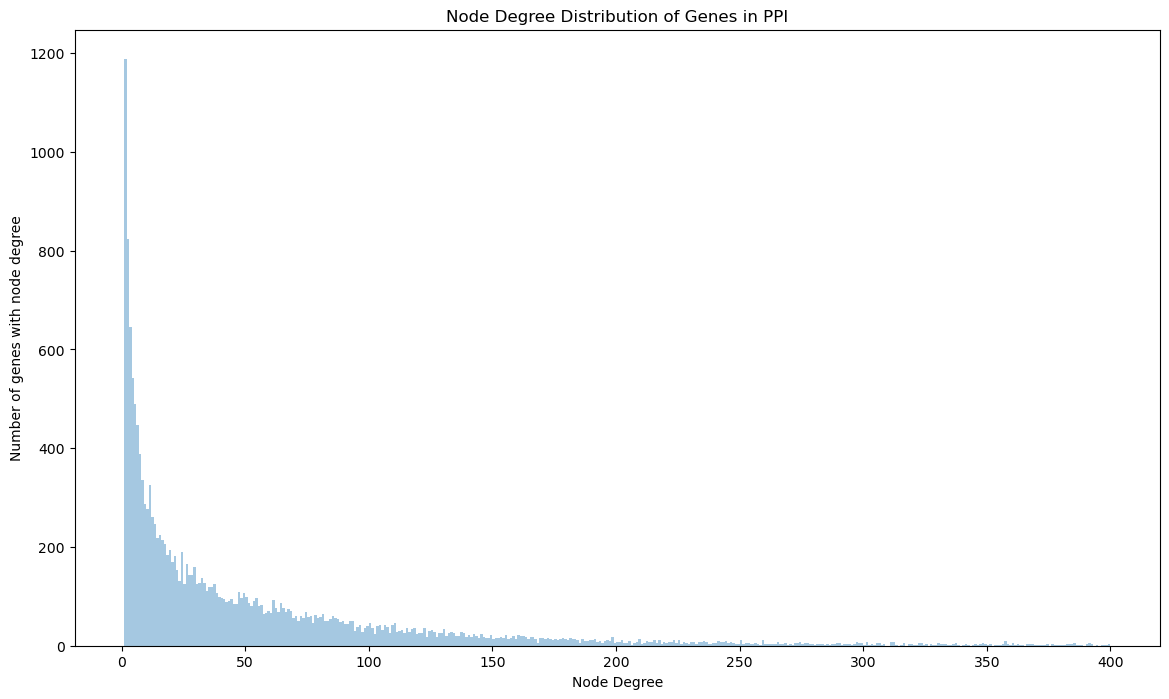

In [18]:

node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 400, 400)

sns.distplot(node_degrees, kde=False, bins=bins) 

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [19]:
df=pd.DataFrame(node_degrees,columns=['node degree'])
df.describe().astype(int)

,node degree
count,17461
mean,65
std,140
min,1
25%,7
50%,27
75%,75
max,4763
